In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt

from one_particle import *
from qca import SimpleQW, x_to_index

In [2]:
EPS = 1e-9

# Some first experiments

We consider a closed chain of length $2L$, positions are labelled by $x=-L, \dots, L-1$. The QW walk is given by $U=WV$ with
$$
W = \begin{pmatrix}
    \alpha T^2 & i\beta T\\
    i\beta T^\dagger & \alpha(T^2)^\dagger
\end{pmatrix}\,,
$$
and 
$$
V = \mathbb{I}+\begin{pmatrix}
    c-1 & is e^{-i\gamma}\\
    is e^{i\gamma} & c-1
\end{pmatrix}\otimes \lvert 0\rangle \langle 0 \rvert\,.
$$
Above, $T\lvert x\rangle = \lvert x+1\rangle$ is the translation operator, $\alpha=\cos{\theta}$, $\beta=\sin{\theta}$, and $c=\cos{\phi}$, $s=\sin{\phi}$

Consider the eigenproblem $U\lvert\psi\rangle = e^{i\omega} \lvert\psi\rangle$. Generically, we have 4 solutions to this equation labelled by momenta $(k, k-\pi, -k, -k+\pi)$.

We consider a QW with the following parameters:

In [3]:
L = 300 
dk = np.pi/L
theta = np.pi/4 
phi = np.pi/4
gamma = 0
qw = SimpleQW(L=L, theta=theta, phi=phi, gamma=gamma)

And we prepare an initial gaussian packet localized at $x_0<0$ travelling to the right with momentum close to $k_0=\pi/4$. In principle we could mix also eigenfunctions with momenta $k_0-\pi, -k_0, -k_0+\pi$, but we only consider $k_0$.

In [4]:
k0 = np.pi/4
sigma_k = 0.1
x0 = -100
qw.psi = qw.wave_packet(k0=k0, sigma_k=sigma_k, x0=x0, sign=1)

The evolution looks like this.

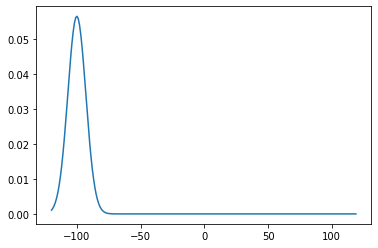

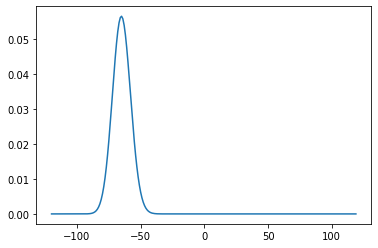

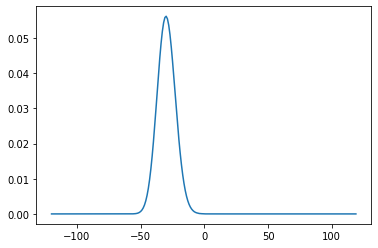

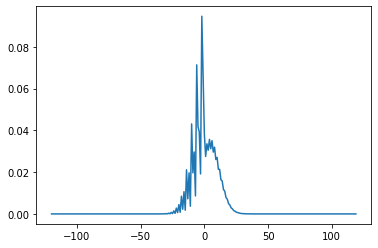

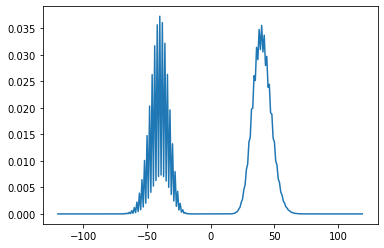

In [5]:
for _ in range(5):
    qw.plot_x(-120, 120)
    plt.show()
    qw.evolve(25)

Above, we have prepared a wave packet with modes with momentum close to $k_0$. Let's see how the probability distribution changes when we mix also the mode with momentum $-k_0$.

In [27]:
qw.psi = normalize(qw.wave_packet(k0=k0, sigma_k=sigma_k, x0=x0, sign=1)+qw.wave_packet(k0=-k0, sigma_k=sigma_k, x0=x0, sign=1))

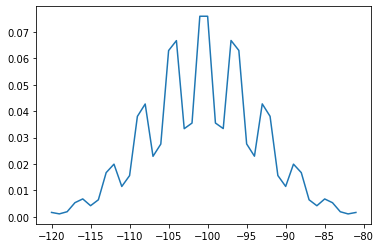

In [28]:
qw.plot_x(-120, -80)

Next we mix modes $k_0$ and $k_0-\pi$. 

In [25]:
qw.psi = normalize(qw.wave_packet(k0=k0, sigma_k=sigma_k, x0=x0, sign=1)+qw.wave_packet(k0=k0-np.pi, sigma_k=sigma_k, x0=x0, sign=1))

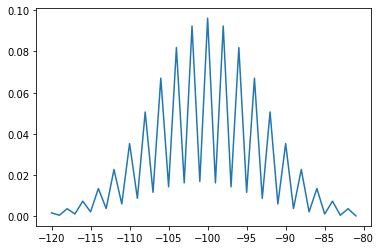

In [26]:
qw.plot_x(-120, -80)